In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/Condition monitoring/RUL Regression/Processed Data/Processed_Train_001.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Condition monitoring/RUL Regression/Processed Data/Processed_Train_002.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Condition monitoring/RUL Regression/Processed Data/Processed_Train_003.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Condition monitoring/RUL Regression/Processed Data/Processed_Train_004.csv')


In [4]:
df=pd.concat([df1,df2,df3,df4])
df

,ID,Cycle,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,605.33,1516.36,1315.28,15.46,404.59,2319.66,8840.16,46.08,380.16,2388.73,8185.69,8.4541,372,29.11,17.5234,4
61245,249,252,643.42,1598.92,1426.77,21.57,567.59,2388.47,9117.12,48.04,535.02,2388.46,8185.47,8.2221,396,39.38,23.7151,3
61246,249,253,643.68,1607.72,1430.56,21.57,569.04,2388.51,9126.53,48.24,535.41,2388.48,8193.94,8.2525,395,39.78,23.8270,2
61247,249,254,555.77,1381.29,1148.18,7.96,199.93,2223.78,8403.64,42.53,187.92,2388.83,8125.64,9.0515,337,15.26,9.0774,1


In [5]:
df.shape

(160359, 18)

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [7]:
# Separate features and target
features = df.columns[2:-1]  # All sensor measurements
target = 'RUL'

In [8]:
# Scale the features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [9]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for id in data['ID'].unique():
        df_subset = data[data['ID'] == id]
        for start in range(len(df_subset) - seq_length + 1):
            end = start + seq_length
            seq_X = df_subset[features].iloc[start:end].values
            seq_y = df_subset[target].iloc[end - 1]
            sequences.append((seq_X, seq_y))
    return sequences

In [10]:
seq_length = 50  # Define your sequence length
sequences = create_sequences(df, seq_length)

In [11]:
# Split sequences into features (X) and target (y)
X, y = zip(*sequences)
X = np.array(X)
y = np.array(y)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 76651 (299.42 KB)
Trainable params: 76651 (299.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

Epoch 1/30
1477/1477 [==============================] - 15s 10ms/step - loss: 7112.6792 - val_loss: 6988.0669
Epoch 2/30
1477/1477 [==============================] - 13s 9ms/step - loss: 7117.0688 - val_loss: 6988.0317
Epoch 3/30
1477/1477 [==============================] - 14s 9ms/step - loss: 7117.7139 - val_loss: 6988.0474
Epoch 4/30
1477/1477 [==============================] - 13s 9ms/step - loss: 7112.3628 - val_loss: 6987.7935
Epoch 5/30
1477/1477 [==============================] - 13s 9ms/step - loss: 7109.9761 - val_loss: 6987.7212
Epoch 6/30
1477/1477 [==============================] - 13s 9ms/step - loss: 7111.2905 - val_loss: 6987.7241
Epoch 7/30
1477/1477 [==============================] - 13s 9ms/step - loss: 7112.5498 - val_loss: 6989.0850
Epoch 8/30
1477/1477 [==============================] - 13s 9ms/step - loss: 7116.7817 - val_loss: 6987.7822
Epoch 9/30
1477/1477 [==============================] - 14s 10ms/step - loss: 7120.2793 - val_loss: 6990.7319
Epoch 10/30
1477/

In [17]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

923/923 [==============================] - 6s 6ms/step - loss: 2050.3230
Test Loss: 2050.322998046875


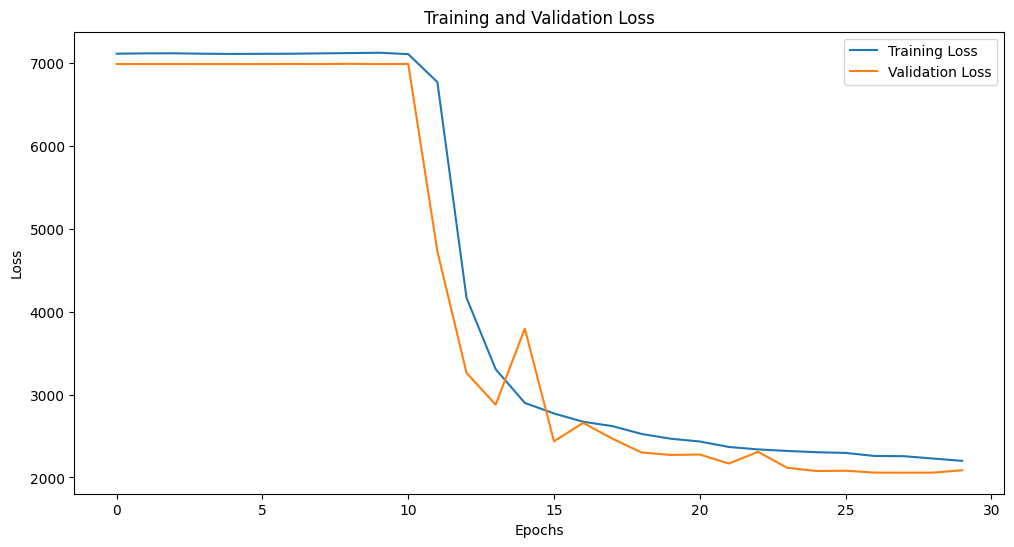

In [18]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

923/923 [==============================] - 3s 3ms/step


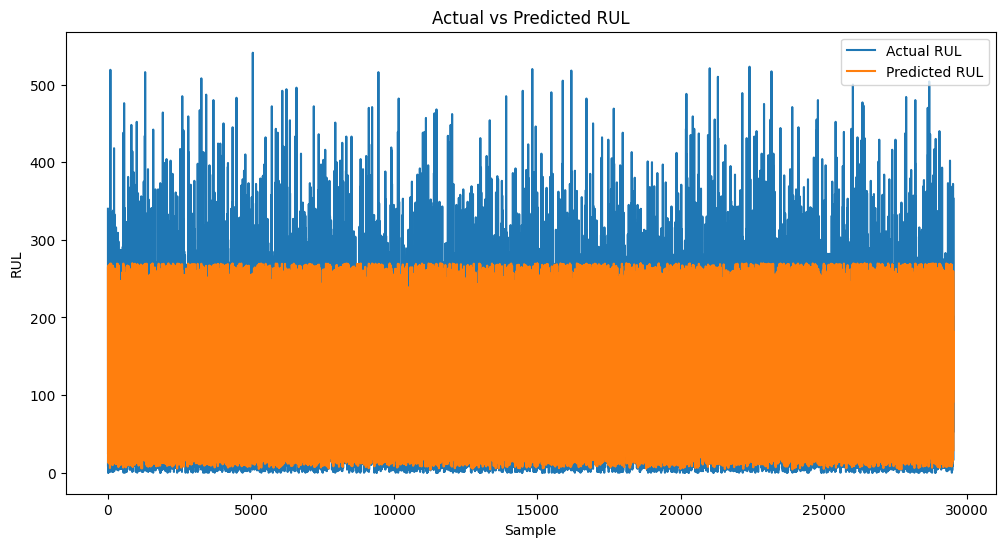

In [21]:
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values if needed
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
#y_pred = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.show()